# Flight Delay Predictor

**Authors:**

Yusuf Medhat

Guillermo Bermejo Babiano 

## Data Loading

To improve the predicting power of the models, we will also take into account two of the available documentation datasets: `airports.csv`, `plane-data.csv` wich will be useful in the following steps.

The dataset `carriers.csv` will not be used as it does not provide any useful information for the purpose of this notebook.

### Session and Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, LongType, IntegerType, DoubleType, DateType
from pyspark.sql.functions import *
from pyspark.sql.functions import col, floor, avg, count, when, greatest

from pyspark.ml.feature import Imputer

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



# Create a SparkSession
spark = SparkSession.builder \
    .appName("FlightDelayPredictor") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/01 14:53:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Flight Dataset Loading

In [2]:
# Specify the list of files to load
files = [
    "../../training_data/flight_data/2006.csv.bz2",
    "../../training_data/flight_data/2007.csv.bz2",
    "../../training_data/flight_data/2008.csv.bz2"
]

# Explicit Schema Definition
# This maps to the 29 columns in your dataset
flight_schema = StructType([
    StructField("Year", IntegerType(), True),
    StructField("Month", IntegerType(), True),
    StructField("DayofMonth", IntegerType(), True),
    StructField("DayOfWeek", IntegerType(), True),
    StructField("DepTime", DoubleType(), True),
    StructField("CRSDepTime", DoubleType(), True),
    StructField("ArrTime", DoubleType(), True),           # Forbidden
    StructField("CRSArrTime", DoubleType(), True),
    StructField("UniqueCarrier", StringType(), True),
    StructField("FlightNum", IntegerType(), True),
    StructField("TailNum", StringType(), True),
    StructField("ActualElapsedTime", DoubleType(), True), # Forbidden
    StructField("CRSElapsedTime", DoubleType(), True),
    StructField("AirTime", DoubleType(), True),           # Forbidden
    StructField("ArrDelay", DoubleType(), True),          # TARGET
    StructField("DepDelay", DoubleType(), True),
    StructField("Origin", StringType(), True),
    StructField("Dest", StringType(), True),
    StructField("Distance", DoubleType(), True),
    StructField("TaxiIn", DoubleType(), True),            # Forbidden
    StructField("TaxiOut", DoubleType(), True),
    StructField("Cancelled", DoubleType(), True),
    StructField("CancellationCode", StringType(), True),
    StructField("Diverted", DoubleType(), True),          # Forbidden
    StructField("CarrierDelay", DoubleType(), True),      # Forbidden
    StructField("WeatherDelay", DoubleType(), True),      # Forbidden
    StructField("NASDelay", DoubleType(), True),          # Forbidden
    StructField("SecurityDelay", DoubleType(), True),     # Forbidden
    StructField("LateAircraftDelay", DoubleType(), True)  # Forbidden
])

# Load them all at once
df_flights = spark.read.csv(files, header=True, schema=flight_schema)

print(f"Total flights loaded: {df_flights.count()}")

Total flights loaded: 16984354


### Airport Dataset Loading

In [3]:
# Specify the list of file
airportFilePath = "../../training_data/documentation/airports.csv"

# Explicit Schema Definition
airport_schema = StructType([
    StructField("iata", StringType(), True),
    StructField("airport", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("country", StringType(), True),
    StructField("lat", DoubleType(), True),
    StructField("long", DoubleType(), True),
])

df_airports = spark.read.csv(airportFilePath, header=True, schema=airport_schema)

print(f"Total airports loaded: {df_airports.count()}")

Total airports loaded: 3376


### Plane Dataset Loading

In [4]:
# Specify the list of file
planeFilePath = "../../training_data/documentation/plane-data.csv"

# Explicit Schema Definition
plane_schema = StructType([
    StructField("tailnum", StringType(), True),
    StructField("type", StringType(), True),
    StructField("manufacturer", StringType(), True),
    StructField("issue_date", DateType(), True),
    StructField("model", StringType(), True),
    StructField("status", StringType(), True),
    StructField("aircraft_type", StringType(), True),
    StructField("engine_type", StringType(), True),
    StructField("year", IntegerType(), True),
])

df_planes = spark.read.csv(planeFilePath, header=True, schema=plane_schema)

print(f"Total planes loaded: {df_planes.count()}")

Total planes loaded: 5029


## Preprocessing & Cleaning

In [5]:
# ==============================================================================
# 1. DROP FORBIDDEN VARIABLES
# ==============================================================================
# These contain information known only AFTER the flight lands.
forbidden_vars = [
    "ArrTime", "ActualElapsedTime", "AirTime", "TaxiIn", "Diverted",
    "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay",
    "CancellationCode"
]
# Only drop columns that actually exist in the dataframe
cols_to_drop = [c for c in forbidden_vars if c in df_flights.columns]
df_clean = df_flights.drop(*cols_to_drop)

# ==============================================================================
# 2. FILTER INVALID ROWS
# ==============================================================================
# Filter Cancelled Flights: If Cancelled == 1, the plane never arrived.
# We also drop the 'Cancelled' column afterwards as it's now constant (all 0)
df_clean = df_clean.filter(col("Cancelled") == 0).drop("Cancelled")

# Drop Missing Targets: We cannot train on data where ArrDelay is missing
df_clean = df_clean.dropna(subset=["ArrDelay", "DepDelay", "Distance"])

print(f"Data Cleaning Complete. Remaining records: {df_clean.count()}")

Data Cleaning Complete. Remaining records: 16598211


## Exploratory Data Analysis (EDA)

In this section, we analyze the cleaned flight data to understand the underlying distributions and relationships. Our goal is to identify key drivers of delay to justify our feature engineering strategy. We focus on three specific hypotheses:

- Temporal Patterns: Are delays concentrated in specific "rush hours" or days?

- Operational Congestion: Do major hubs experience higher average delays than smaller airports?

- Equipment Reliability: Does the age of the aircraft correlate with delay frequency?

In [6]:
# Due to the size of the dataset, we cache it in memory for faster access
df_clean.cache()
print(f"Dataset cached. Total rows: {df_clean.count()}")

Dataset cached. Total rows: 16598211


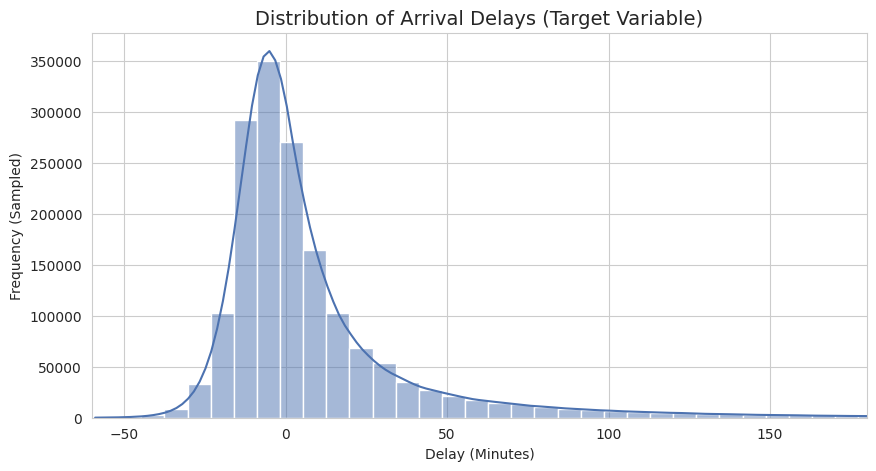

In [7]:
# ==============================================================================
# 1. Analysis of the distribution of the Target Variable (ArrDelay)
# ==============================================================================
# We sample the data for the histogram because plotting millions of points is slow/impossible
# We filter extreme outliers (>300 mins) just for the visualization clearly
target_sample = df_clean.select("ArrDelay") \
                        .filter((col("ArrDelay") > -60) & (col("ArrDelay") < 300)) \
                        .sample(withReplacement=False, fraction=0.1, seed=42) \
                        .toPandas()

plt.figure(figsize=(10, 5))
sns.histplot(target_sample['ArrDelay'], bins=50, kde=True, color="#4C72B0")
plt.title("Distribution of Arrival Delays (Target Variable)", fontsize=14)
plt.xlabel("Delay (Minutes)")
plt.ylabel("Frequency (Sampled)")
plt.xlim(-60, 180) # Focus on the main body of data
plt.show()

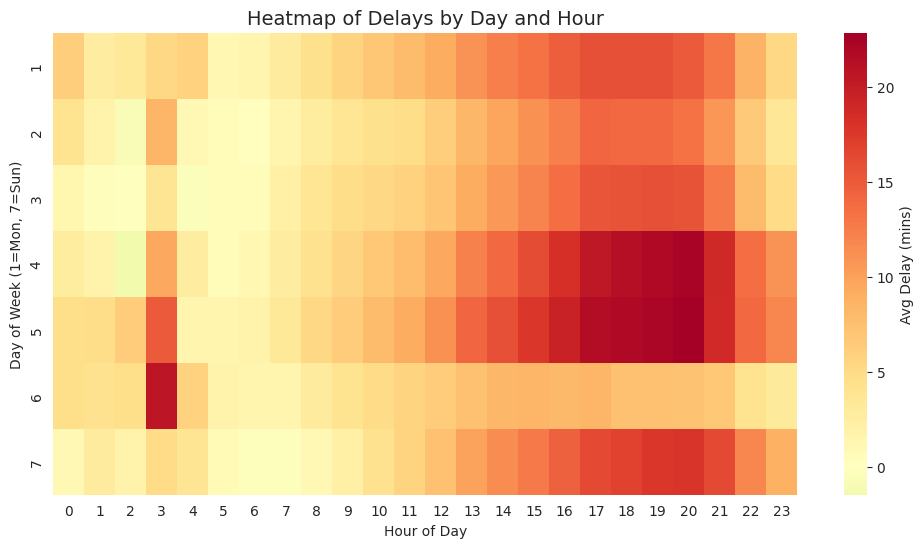

In [8]:
# ==============================================================================
# 2. Time Analysis (Are there specific days/hours with more delays?)
# ==============================================================================
# Create a temporary Hour column for this plot
# Divide by 100 to get the hour from HHMM format
time_df = df_clean.withColumn("DepHour", floor(col("CRSDepTime") / 100))

# Aggregation: Average delay by Day of Week and Hour
heatmap_data = time_df.groupBy("DayOfWeek", "DepHour") \
                      .agg(avg("ArrDelay").alias("AvgDelay")) \
                      .orderBy("DayOfWeek", "DepHour") \
                      .toPandas()

# Heatmap
heatmap_pivot = heatmap_data.pivot(index="DayOfWeek", columns="DepHour", values="AvgDelay")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="RdYlGn_r", center=0, cbar_kws={'label': 'Avg Delay (mins)'})
plt.title("Heatmap of Delays by Day and Hour", fontsize=14)
plt.ylabel("Day of Week (1=Mon, 7=Sun)")
plt.xlabel("Hour of Day")
plt.show()

/tmp/ipykernel_16217/569426934.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="AirportType", y="AvgDelay", data=hub_stats, palette="viridis")


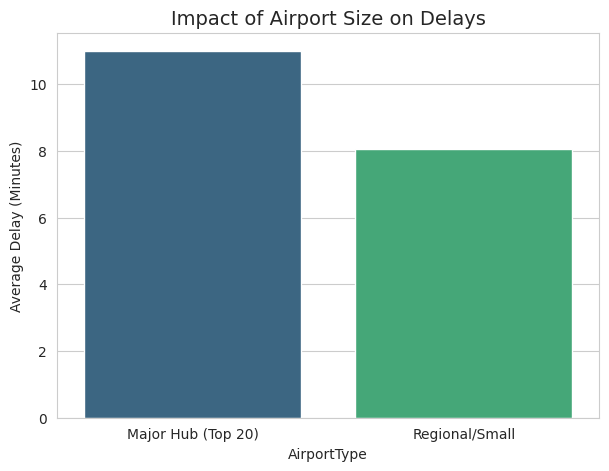

In [9]:
# ==============================================================================
# 3. Location Analysis (Are certain airports more prone to delays?)
# ==============================================================================
# Identify Top 20 Airports by number of departures
top_airports = df_clean.groupBy("Origin").count().orderBy(col("count").desc()).limit(20)
top_20_list = [row["Origin"] for row in top_airports.collect()]

# Tag airports as "Hub" or "Regional"
hub_df = df_clean.withColumn("AirportType", 
                             when(col("Origin").isin(top_20_list), "Major Hub (Top 20)")
                             .otherwise("Regional/Small"))

# Aggregate
hub_stats = hub_df.groupBy("AirportType") \
                  .agg(avg("ArrDelay").alias("AvgDelay")) \
                  .toPandas()

plt.figure(figsize=(7, 5))
sns.barplot(x="AirportType", y="AvgDelay", data=hub_stats, palette="viridis")
plt.title("Impact of Airport Size on Delays", fontsize=14)
plt.ylabel("Average Delay (Minutes)")
plt.show()

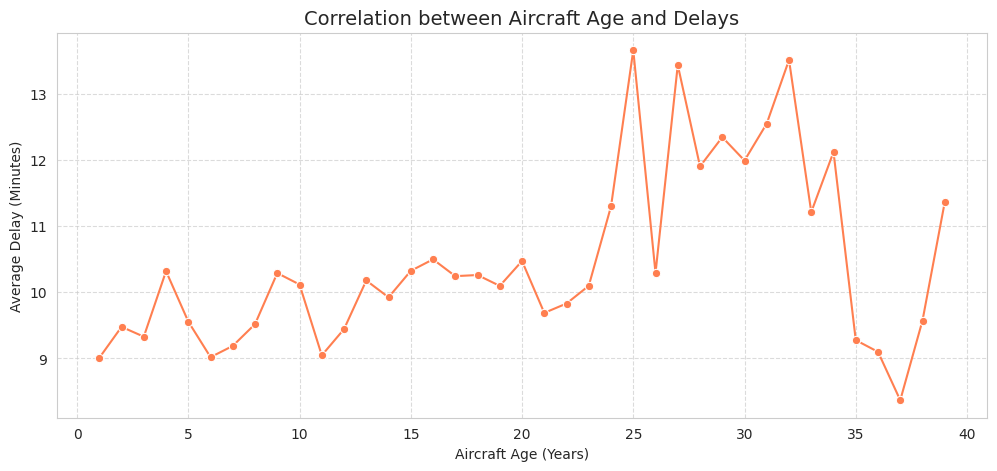

In [10]:
# ==============================================================================
# 4. Mechanic Analysis (Is the Age of the Aircraft correlated with Delays?)
# ==============================================================================
# We perform a temporary join just for this plot to prove 'PlaneAge' is useful
plane_age_df = df_clean.join(df_planes.withColumnRenamed("year", "PlaneYear"), df_clean.TailNum == df_planes.tailnum) \
                       .select((col("Year") - col("PlaneYear").cast("int")).alias("PlaneAge"), "ArrDelay") \
                       .filter((col("PlaneAge") > 0) & (col("PlaneAge") < 40)) # Filter impossible ages

# Aggregate by Age
age_stats = plane_age_df.groupBy("PlaneAge") \
                        .agg(avg("ArrDelay").alias("AvgDelay"), count("*").alias("FlightCount")) \
                        .filter(col("FlightCount") > 100) \
                        .orderBy("PlaneAge") \
                        .toPandas()

plt.figure(figsize=(12, 5))
sns.lineplot(x="PlaneAge", y="AvgDelay", data=age_stats, marker="o", color="coral")
plt.title("Correlation between Aircraft Age and Delays", fontsize=14)
plt.xlabel("Aircraft Age (Years)")
plt.ylabel("Average Delay (Minutes)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

/tmp/ipykernel_16217/331157432.py:32: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="State", y="AvgDelay", data=subset_states, palette="coolwarm")


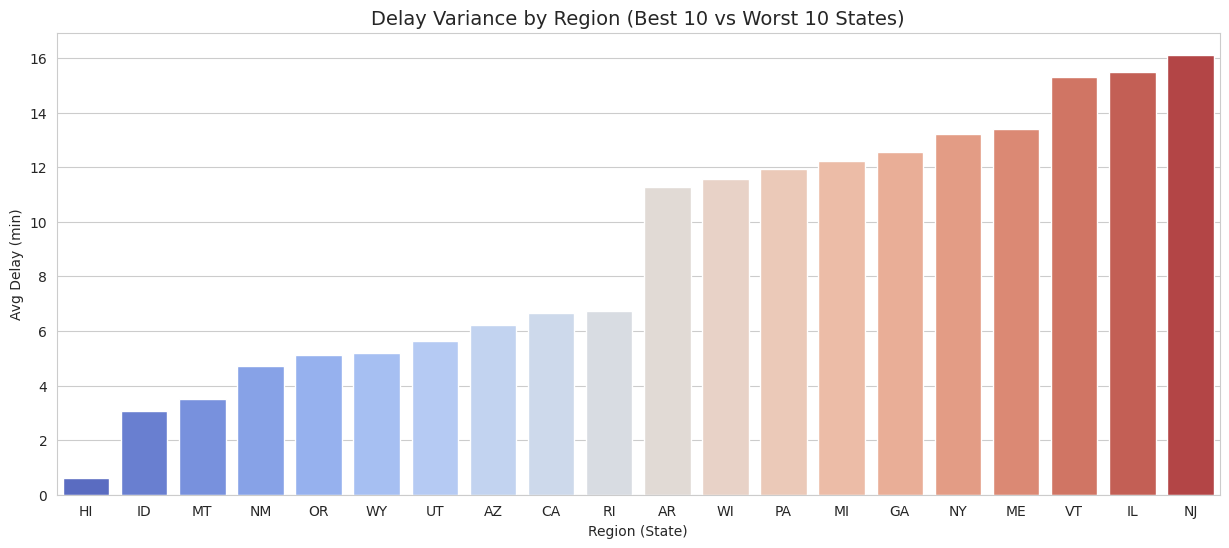

In [27]:
# ==============================================================================
# 5. STATE VS AIRPORT (Dimensionality Reduction)
# ==============================================================================
# Hypothesis: "State" captures enough pattern that we don't need OHE for 300+ airports.

# 1. Join Airport Data to get State/Lat/Long
# We rename columns immediately to avoid ambiguity
airports_eda = df_airports.select(
    col("iata").alias("Code"), 
    col("state").alias("State"), 
    col("lat").alias("Lat"), 
    col("long").alias("Long")
)

# Join just the Origin to simplify the analysis
df_geo = df_clean.join(airports_eda, df_clean.Origin == airports_eda.Code, how="left")

# 2. Aggregation by State
state_stats = df_geo.groupBy("State") \
                    .agg(
                        avg("ArrDelay").alias("AvgDelay"), 
                        count("*").alias("FlightCount")
                    ) \
                    .filter(col("FlightCount") > 1000) \
                    .orderBy("AvgDelay") \
                    .toPandas()

# 3. Plot: State Variance
plt.figure(figsize=(15, 6))
# Show top 10 worst and top 10 best states to show the SPREAD of the data
subset_states = pd.concat([state_stats.head(10), state_stats.tail(10)])
sns.barplot(x="State", y="AvgDelay", data=subset_states, palette="coolwarm")
plt.title("Delay Variance by Region (Best 10 vs Worst 10 States)", fontsize=14)
plt.ylabel("Avg Delay (min)")
plt.xlabel("Region (State)")
plt.show()

+------+-------+
|LatBin|  count|
+------+-------+
|    15|   2540|
|    20| 216756|
|    25| 328708|
|    30|2517832|
|    35|5315229|
|    40|7164575|
|    45| 926328|
|    55|  25947|
|    60|  90454|
|    65|   4755|
|    70|   5087|
+------+-------+



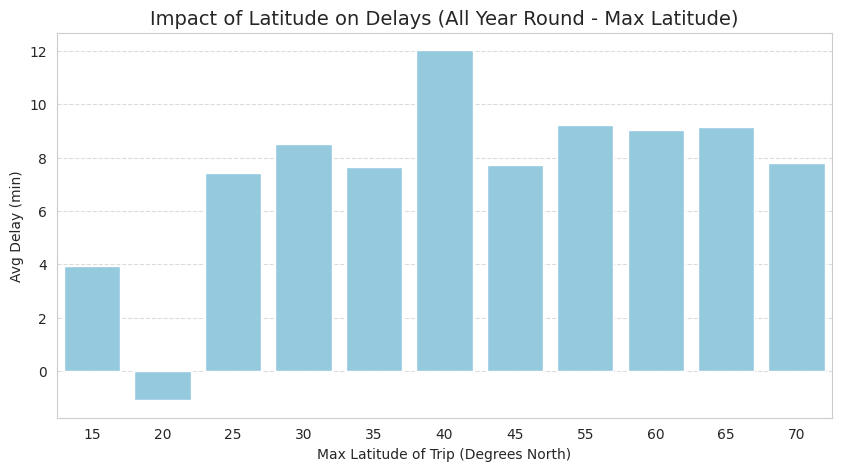

In [31]:
# ==============================================================================
# 6.1 LATITUDE ANALYSIS (All Year Round)
# ==============================================================================
# Hypothesis: Does higher latitude (Origin OR Dest) correlate with delays annually (icier and colder climates)?

# 1. Get Destination Latitude
dest_coords = airports_eda.select(col("Code").alias("DestCode"), col("Lat").alias("DestLat"))
df_all_year = df_geo.join(dest_coords, df_geo.Dest == dest_coords.DestCode, how="left")


# 2. Create 'TripLat' (The Max Latitude of the journey)
# Captures if the flight touches a Northern airport at either end.
df_all_year = df_all_year.withColumn("TripLat", greatest(col("Lat"), col("DestLat")))

# 3. Bin the Max Latitude
df_all_year = df_all_year.withColumn("LatBin", floor(col("TripLat") / 5) * 5)

# 4. Aggregate
lat_stats_all_year = df_all_year.groupBy("LatBin") \
    .agg(avg("ArrDelay").alias("AvgDelay")) \
    .orderBy("LatBin") \
    .toPandas()

df_all_year.groupBy("LatBin").count().orderBy("LatBin").show()

# 5. Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="LatBin", y="AvgDelay", data=lat_stats_all_year, color="skyblue")

plt.title("Impact of Latitude on Delays (All Year Round - Max Latitude)", fontsize=14)
plt.xlabel("Max Latitude of Trip (Degrees North)")
plt.ylabel("Avg Delay (min)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

+------+-------+
|LatBin|  count|
+------+-------+
|    15|    696|
|    20|  57895|
|    25|  91424|
|    30| 693722|
|    35|1466397|
|    40|1955329|
|    45| 247979|
|    55|   5933|
|    60|  20626|
|    65|   1295|
|    70|   1396|
+------+-------+



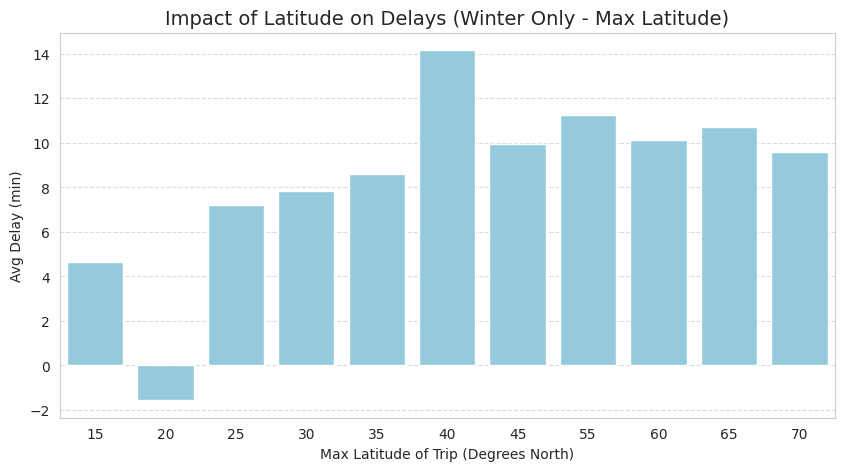

In [ ]:
# ==============================================================================
# 6.2 LATITUDE ANALYSIS (Winter Only)
# ==============================================================================
# Hypothesis: Will there be a stronger correlation between latitude and delays in Winter (Dec, Jan, Feb)?

# 1. Filter the EXISTING 'df_all_year' dataframe
# We don't need to join or recalculate TripLat/LatBin; it's already there!
df_winter_max = df_all_year.filter(col("Month").isin([12, 1, 2]))

# 2. Aggregate
lat_stats_winter_max = df_winter_max.groupBy("LatBin") \
    .agg(avg("ArrDelay").alias("AvgDelay")) \
    .orderBy("LatBin") \
    .toPandas()

df_winter_max.groupBy("LatBin").count().orderBy("LatBin").show()

# 3. Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="LatBin", y="AvgDelay", data=lat_stats_winter_max, color="skyblue")

plt.title("Impact of Latitude on Delays (Winter Only - Max Latitude)", fontsize=14)
plt.xlabel("Max Latitude of Trip (Degrees North)")
plt.ylabel("Avg Delay (min)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipykernel_16217/1105504841.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="RiskCategory", y="AvgDelay", data=risk_stats, palette="Reds")


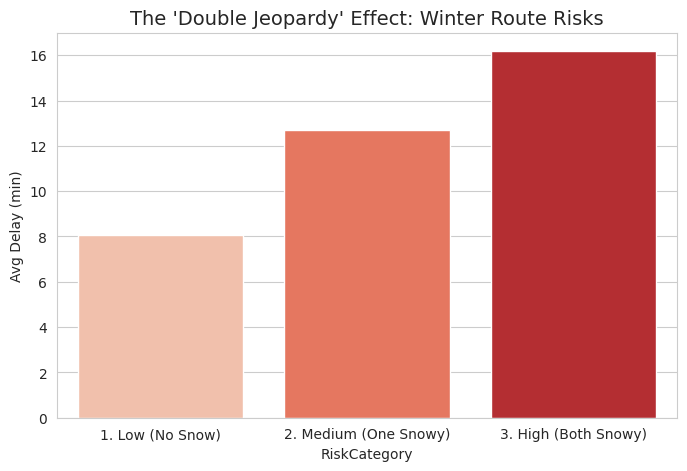

In [ ]:
# ==============================================================================
# 6.3 ROUTE RISK PROFILE (Double Jeopardy Test)
# ==============================================================================
# Explanation: Before, we were looking at the MAX latitude of the trip. Now, we
#  will categorize routes based on whether BOTH airports are North of a certain latitude.
#
# Hypothesis: Flights where BOTH airports are North are riskier than just one.


# 1. Define the "Snow Line"
# We chose 40 degrees, as, afters seeing previous charts, and doing some research, this is
#  the latitude of the so called "winter belt" in the US.
SNOW_LINE = 40

# 2. Join Destination Latitude
dest_coords = airports_eda.select(col("Code").alias("DestCode"), col("Lat").alias("DestLat"))
df_risk_cat = df_geo.join(dest_coords, df_geo.Dest == dest_coords.DestCode, how="left")

# 3. Create Categories
# - High Risk: Both Origin AND Dest are > 40
# - Medium Risk: Either Origin OR Dest is > 40 (but not both)
# - Low Risk: Neither is > 40
df_risk_cat = df_risk_cat.withColumn("RiskCategory", 
    when((col("Lat") >= SNOW_LINE) & (col("DestLat") >= SNOW_LINE), "3. High (Both Snowy)")
    .when((col("Lat") >= SNOW_LINE) | (col("DestLat") >= SNOW_LINE), "2. Medium (One Snowy)")
    .otherwise("1. Low (No Snow)")
)

# 4. Filter for Winter Only
df_risk_winter = df_risk_cat.filter(col("Month").isin([12, 1, 2]))

# 5. Aggregate
risk_stats = df_risk_winter.groupBy("RiskCategory") \
    .agg(avg("ArrDelay").alias("AvgDelay")) \
    .orderBy("RiskCategory") \
    .toPandas()

# 6. Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="RiskCategory", y="AvgDelay", data=risk_stats, palette="Reds")
plt.title("The 'Double Jeopardy' Effect: Winter Route Risks", fontsize=14)
plt.ylabel("Avg Delay (min)")
plt.show()

/tmp/ipykernel_16217/1060467753.py:23: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Direction", y="AvgDelay", data=dir_stats, palette="Set2")


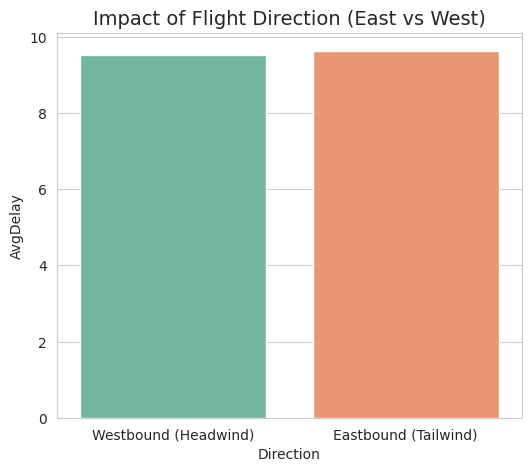

In [ ]:
# ==============================================================================
# 7. FLIGHT DIRECTION (Eeast vs. West)
# ==============================================================================
# Explanation: In the US, prevailing winds generally blow from West to East.
#
# Hypothesis: Flying East (Tailwind) recovers time? Flying West (Headwind) loses time?


# We need Destination Longitude to calculate direction
dest_coords = airports_eda.select(col("Code").alias("DestCode"), col("Long").alias("DestLong"))
df_direction = df_geo.join(dest_coords, df_geo.Dest == dest_coords.DestCode, how="left")

# Calculate Difference of Longitude
# Positive = Eastbound, Negative = Westbound
df_direction = df_direction.withColumn("Direction", 
                                       when((col("DestLong") - col("Long")) > 0, "Eastbound (Tailwind)")
                                       .otherwise("Westbound (Headwind)"))

dir_stats = df_direction.groupBy("Direction") \
                        .agg(avg("ArrDelay").alias("AvgDelay")) \
                        .toPandas()

plt.figure(figsize=(6, 5))
sns.barplot(x="Direction", y="AvgDelay", data=dir_stats, palette="Set2")
plt.title("Impact of Flight Direction (East vs West)", fontsize=14)
plt.show()

/tmp/ipykernel_16217/1207575178.py:24: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Direction", y="AvgDelay", data=dir_stats, palette="Set2")


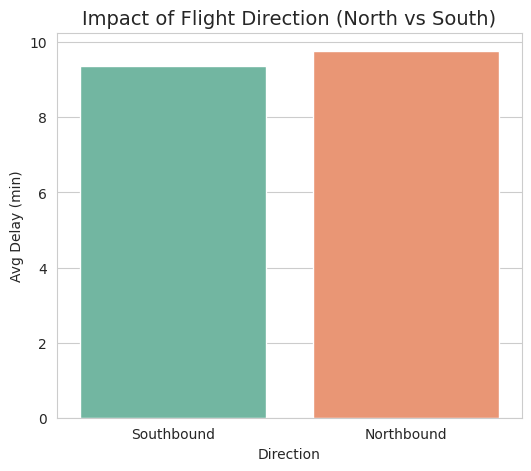

In [ ]:
# ==============================================================================
# 8. FLIGHT DIRECTION (North vs. South)
# ==============================================================================
# Hypothesis: Does flying North vs. South impact delays? 

# Get Destination Latitude
dest_coords = airports_eda.select(col("Code").alias("DestCode"), col("Lat").alias("DestLat"))

# Join to get DestLat alongside Origin Lat
df_direction = df_geo.join(dest_coords, df_geo.Dest == dest_coords.DestCode, how="left")

# Calculate Direction based on Latitude
# If DestLat > Origin Lat = Northbound
df_direction = df_direction.withColumn("Direction", 
                                       when((col("DestLat") - col("Lat")) > 0, "Northbound")
                                       .otherwise("Southbound"))

# Plot
dir_stats = df_direction.groupBy("Direction") \
                        .agg(avg("ArrDelay").alias("AvgDelay")) \
                        .toPandas()

plt.figure(figsize=(6, 5))
sns.barplot(x="Direction", y="AvgDelay", data=dir_stats, palette="Set2")
plt.title("Impact of Flight Direction (North vs South)", fontsize=14)
plt.ylabel("Avg Delay (min)")
plt.show()

### Conclusion of EDA
#### 1. Distribution of Arrival Delays

#### 2. HeatMap of Delays by day of the week and hour

#### 3. Impact of airport size on the delay

#### 4. Correlation between aircraft age and delays

#### 5. Delay variance by region (best 10 vs worst 10)

#### 6. Impact of the latitude on delays (North vs. South)

#### 7. Impact of the flight direction (East vs. West)

## Feature Engineering

1. **Aircraft data join**

   Join with `plane-data` to add aircraft-level attributes:

   * `manufacturer`
   * `model`
   * `aircraft`
   * `enginetype`
   * `age = year_flight - year_plane`

   Aircraft age is used as a proxy for reliability and maintenance effects.
   Drop `type`, `status` (no variance), and `issue_date` (not relevant for operations).

2. **Airport data join**

   Join airport metadata to both origin and destination:

   * `lat_ori`, `lon_ori`
   * `lat_dest`, `lon_dest`

   Coordinates are used to capture geographic and weather-related effects.

   Derived directional features:

   * `east_west`: 1 if eastbound, 0 if westbound
   * `north_south`: 1 if northbound, 0 if southbound

   These encode large-scale directional patterns (e.g. jet streams, traffic flows) without modeling full trajectories.

3. **Airport representation**

   Raw airport codes are not used due to high cardinality. Instead:

   * `is_hub`: binary indicator for Top 20 busiest airports (congestion proxy)
   * `region`: broad geographic region

   This retains operational signal while limiting dimensionality and overfitting risk.

## Model Training & Tuning

## Evaluation & Saving